We are given time steps: $\tau_n$ with step size $\Delta \tau$, spatial steps $X_i$ with step size $\Delta X$ and
\begin{equation}
    f_i^n = f(X_i, \tau_n)$, \quad $g_i^n = g(X_i, \tau_n).
\end{equation}
We use standard finite difference approximations for the derivatives. For the time derivative, we use a forward difference approximation
\begin{equation}
    \frac{\partial f}{\partial \tau} \approx \frac{f_i^{n+1} - f_i^n}{\Delta \tau}.
\end{equation}
For the spatial second derivative, we use a central difference approximation
\begin{equation}
    \frac{\partial^2 g}{\partial X^2} \approx \frac{g_{i+1}^n - 2g_i^n + g_{i-1}^n}{(\Delta X)^2}.
\end{equation}
We have by equating both sides
\begin{equation}
    \frac{f_i^{n+1} - f_i^n}{\Delta \tau} = \frac{g_{i+1}^n - 2g_i^n + g_{i-1}^n}{(\Delta X)^2}
\end{equation}
Rearranging yields the recurrence
\begin{equation}
    f_i^{n+1} = f_i^n + \frac{\Delta \tau}{(\Delta X)^2} (g_{i+1}^n - 2g_i^n + g_{i-1}^n).
\end{equation}
For formal stability the timestep must
satisfy
\begin{equation}
    \Delta\tau \leq \frac{1}{2}(\Delta X)^2\frac{f}{g} = \frac{2}{3} (\Delta X)^2 X^2
\end{equation}
at all points in the disc.

Take $\eta = 1$ with the boundary conditions $\sigma(r_{\text{in}}, \tau) = 0$ and $\sigma(r_{\text{out}}, \tau) = 0$. We shall evolve from an initial mass distribution
\begin{equation}
    \sigma(r, 0) = \exp\left(-\frac{(r^{1/2} − 1)^2}{0.001}\right).
\end{equation}


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def compute_f(sigma, X):
    '''
    Computes the conserved variable f = 4 * X^3 * sigma.
    '''
    return 4 * (X**3) * sigma

def compute_g(sigma, X, eta=1.0):
    '''
    Computes the flux variable g = 3 * eta * X * sigma.
    '''
    return 3 * eta * X * sigma

def compute_sigma(f, X):
    '''
    Recovers sigma from f.
    '''
    # X > 0 is assumed based on grid definition
    return f / (4 * X**3)

def initial_condition(r):
    '''
    Returns the initial sigma distribution.
    '''
    return np.exp(-((r**0.5 - 1)**2) / 0.001)

In [4]:
def setup_grid(x_min, x_max, n_points):
    '''
    Generates the spatial grid X and radius r.
    Returns: X, r, dX
    '''
    X = np.linspace(x_min, x_max, n_points)
    r = X**2
    dX = (x_max - x_min) / (n_points - 1)
    return X, r, dX

def get_stable_timestep(dX, X_min, safety_factor=0.9):
    '''
    Calculates the maximum stable timestep.
    Stability condition: dt <= (2/3) * dX^2 * X^2
    We use X_min as it provides the strictest constraint.
    '''
    dt_limit = (2.0/3.0) * (dX**2) * (X_min**2)
    return dt_limit * safety_factor

def perform_single_step(f, g, dt, dX):
    '''
    Performs a single time step integration using finite differences.
    Equation: f_new = f_old + (dt / dX^2) * (g_next - 2g + g_prev)
    '''
    # Calculate central difference for g (interior points)
    g_diff = g[2:] - 2*g[1:-1] + g[:-2]

    # Update f (interior points only)
    f[1:-1] += (dt / (dX**2)) * g_diff
    return f

def run_simulation(X, r, dX, dt, target_times):
    '''
    Runs the full time evolution.
    '''
    # Initialise state
    sigma = initial_condition(r)

    # Apply boundary conditions (sigma = 0 at edges)
    sigma[0] = 0.0
    sigma[-1] = 0.0

    # Convert to computational variable f
    f = compute_f(sigma, X)

    current_time = 0.0
    results = [(0.0, sigma.copy())]

    # Loop through each target output time
    for target in target_times:
        while current_time < target:
            # Determine step size (don't overshoot target)
            if current_time + dt > target:
                step_dt = target - current_time
            else:
                step_dt = dt

            # Compute g based on current sigma
            g = compute_g(sigma, X)

            # Update f
            f = perform_single_step(f, g, step_dt, dX)

            # Recover sigma
            sigma = compute_sigma(f, X)

            # Enforce Boundary Conditions
            sigma[0] = 0.0
            sigma[-1] = 0.0

            current_time += step_dt

        # Save snapshot
        results.append((target, sigma.copy()))
        print(f"Reached time tau = {target}")

    return results

def plot_results(results, r_grid):
    '''
    Plots the surface density evolution.
    '''
    plt.figure(figsize=(8, 5))

    for time, sigma in results:
        label_str = r'$\tau = 0$' if time == 0 else f'$\\tau = {time}$'
        plt.plot(r_grid, sigma, label=label_str)

    plt.xlabel(r'Dimensionless Radius $r = R/R_0$')
    plt.ylabel(r'Dimensionless Surface Density $\sigma$')
    plt.title(r'Evolution of Surface Density $\sigma(r, \tau)$')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 4)
    plt.show()

Reached time tau = 0.002
Reached time tau = 0.008
Reached time tau = 0.032
Reached time tau = 0.128
Reached time tau = 0.512


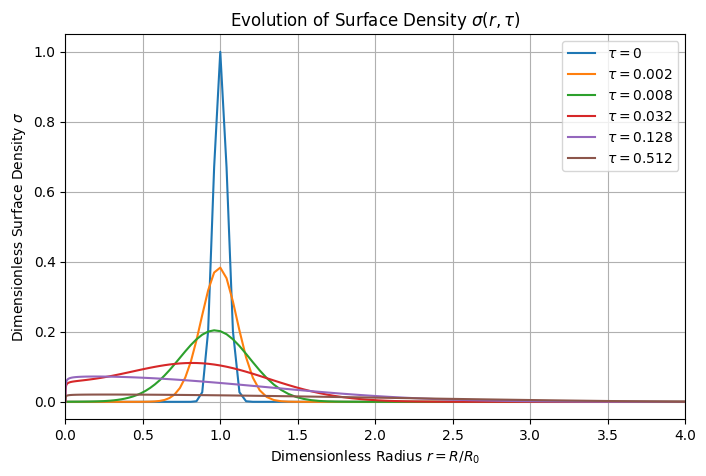

In [5]:
eta = 1.0
N_points = 100
X_min = 0.02
X_max = 2.0
target_times = [0.002, 0.008, 0.032, 0.128, 0.512]
X, r, dX = setup_grid(X_min, X_max, N_points)
dt = get_stable_timestep(dX, X_min)
simulation_results = run_simulation(X, r, dX, dt, target_times)
plot_results(simulation_results, r)

The initial state is a sharp Gaussian-like peak centered at $r=1$. As time progresses, the peak diffuses and the amplitude decreases, conserving angular momentum and mass globally but redistributing it locally. Matter moves inwards and once it hits the inner $r=0$ boundary, it is accreted, causing the density to drop significantly at later times. The spreading is asymmetric because the diffusivity depends on $X$.

In [11]:
def get_peak_properties(sigma, r):
    '''
    Returns the max value of sigma and the radius r where it occurs.
    '''
    idx = np.argmax(sigma)
    return sigma[idx], r[idx]

def get_total_angular_momentum(sigma, X, dX):
    '''
    Computes total angular momentum proportional to integral(sigma * r^3/2 dr).
    '''
    integrand = 2 * sigma * (X**4)
    # Use trapezoidal integration
    return np.trapezoid(integrand, dx=dX)

def get_peak_am_density_position(sigma, X, r):
    '''
    Finds the position r where the angular momentum surface density is maximised.
    '''
    am_density = sigma * X
    idx = np.argmax(am_density)
    return r[idx]

In [14]:
def run_analysis_simulation():
    # Grid Parameters
    eta = 1.0
    N_points = 100
    X_min = 0.02
    X_max = 2.0
    X, r, dX = setup_grid(X_min, X_max, N_points)

    # Time Parameters
    dt = get_stable_timestep(dX, X_min)

    target_times = [0.002, 0.008, 0.032, 0.128, 0.512]

    # Initialisation
    sigma = initial_condition(r)
    sigma[0] = 0.0
    sigma[-1] = 0.0
    f = compute_f(sigma, X)

    current_time = 0.0

    # Storage for table (discrete events)
    table_data = []

    # Storage for time evolution plots (continuous history)
    history_time = [0.0]
    history_L_tot = [get_total_angular_momentum(sigma, X, dX)]
    history_peak_am_pos = [get_peak_am_density_position(sigma, X, r)]

    # Check initial state for table
    for target in target_times:
        while current_time < target:
            # Determine step
            if current_time + dt > target:
                step_dt = target - current_time
            else:
                step_dt = dt

            # Physics step
            g = compute_g(sigma, X)
            f = perform_single_step(f, g, step_dt, dX)

            sigma = compute_sigma(f, X)
            sigma[0] = 0.0
            sigma[-1] = 0.0

            current_time += step_dt

            # Record continuous history every step
            history_time.append(current_time)
            history_L_tot.append(get_total_angular_momentum(sigma, X, dX))
            history_peak_am_pos.append(get_peak_am_density_position(sigma, X, r))

        # Re-ensure exact boundary conditions and snapshot for analysis
        sigma[0] = 0.0
        sigma[-1] = 0.0

        # Collect table data
        peak_val, peak_pos = get_peak_properties(sigma, r)
        table_data.append({
            "time": target,
            "peak_sigma": peak_val,
            "peak_r": peak_pos
        })
        print(f"Reached time tau = {target}")

    return table_data, history_time, history_L_tot, history_peak_am_pos

Reached time tau = 0.002
Reached time tau = 0.008
Reached time tau = 0.032
Reached time tau = 0.128
Reached time tau = 0.512

Table: Peak Surface Density and Position
Time (tau)      | Peak Sigma      | Position (r)   
--------------------------------------------------
0.002           | 0.38349         | 1.0000         
0.008           | 0.20433         | 0.9604         
0.032           | 0.11103         | 0.8100         
0.128           | 0.07233         | 0.1936         
0.512           | 0.02078         | 0.2704         


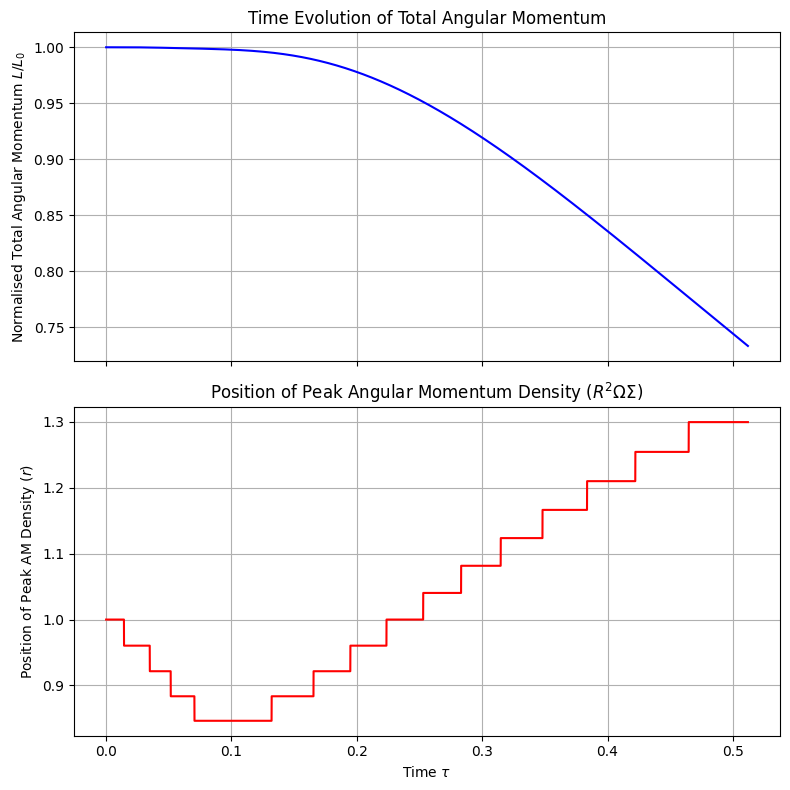

In [15]:
table_data, t_hist, L_hist, r_am_peak_hist = run_analysis_simulation()

print("\nTable: Peak Surface Density and Position")
print(f"{'Time (tau)':<15} | {'Peak Sigma':<15} | {'Position (r)':<15}")
print("-" * 50)
for row in table_data:
    print(f"{row['time']:<15.3f} | {row['peak_sigma']:<15.5f} | {row['peak_r']:<15.4f}")

L0 = L_hist[0]
L_norm = [L / L0 for L in L_hist]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

ax1.plot(t_hist, L_norm, 'b-')
ax1.set_ylabel(r'Normalised Total Angular Momentum $L/L_0$')
ax1.set_title('Time Evolution of Total Angular Momentum')
ax1.grid(True)

ax2.plot(t_hist, r_am_peak_hist, 'r-')
ax2.set_ylabel(r'Position of Peak AM Density ($r$)')
ax2.set_xlabel(r'Time $\tau$')
ax2.set_title(r'Position of Peak Angular Momentum Density ($R^2\Omega\Sigma$)')
ax2.grid(True)

plt.tight_layout()
plt.show()

There is a monotonic decrease in total angular momentum over time which starts only after a transient period. This happens because after the peak touches the boundary, matter is accreting onto the central object at the inner boundary $R_{\text{in}}$. When mass leaves the computational grid at the inner edge, it carries away its specific angular momentum.

The position of the peak surface density decreases rapidly, as seen in the table. This reflects the nature of an accretion disc where viscous forces allow matter to lose energy and drop down into the potential well of the central object.

The peak of the surface density $\Sigma$ initially moves rapidly inwards. This behaviour is due to the viscous forces which allow matter to lose energy and drop into the potential well of the central object. For mass to move inwards, it must lose angular momentum to the outer parts of the disc via viscous torques.